In [2]:
import math
import json
import numpy as np
import matplotlib.pyplot as plt
from phe import paillier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### load_data()
1. 加载乳腺癌数据集    
2. 返回处理好的训练集、训练集标签、测试集、测试集标签
3. 数据拆分，将数据集随机划分为训练集和测试集，其中random_state为随机数种子，保证每次划分结果一致
4. 数据标准化，使用StandardScaler进行数据标准化（z-score标准化）

In [3]:
def load_data():
    breast = load_breast_cancer()
    X_train, X_test, y_train, y_test = train_test_split(breast.data, breast.target, random_state=1)
    
    std = StandardScaler()
    X_train = std.fit_transform(X_train)
    X_test = std.transform(X_test)
    return X_train, y_train, X_test, y_test

### vertically_partition_data()
将样本进一步拆分，分配给guest方A和host方B，A获得部分特征数据，B获得部分特征数据与标签数据。

In [4]:
def vertically_partition_data(X, X_test, A_idx, B_idx):
    XA = X[:, A_idx]  
    XB = X[:, B_idx]  
    XB = np.c_[np.ones(X.shape[0]), XB]
    XA_test = X_test[:, A_idx]
    XB_test = X_test[:, B_idx]
    XB_test = np.c_[np.ones(XB_test.shape[0]), XB_test]
    return XA, XB, XA_test, XB_test

### 预测函数（sigmoid激活函数）
$$ y = \frac{1}{1+e^{-w^{T}x}}$$
输入测试集与权重矩阵，计算预测值

In [5]:
pred1,pred2=[],[]
# sigmoid
def predict_sigmoid(weights, X_test):
    z = np.dot(weights, X_test.T) 
    y_pred = 1/(1+np.exp(-z))
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5]= 0
    return y_pred

### 输入真实标签和预测值，返回值accuracy, precision, recall 和 F1 score

In [6]:
# 计算accuracy...
def calculate_metrics(y_true, y_pred):
    """
    Calculate accuracy, precision, recall and F1 score
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: accuracy, precision, recall, F1 score
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

### 绘制随着eposh轮次增加，每轮loss和accuracy的变化曲线

In [7]:
def loss_acc_fig(loss_A, accuracy_A, loss_B, accuracy_B):
    fig = plt.figure(figsize=(12, 6))
    x=[i+1 for i in range(len(loss_A))]
    plt.subplot(1, 2, 1)
    l1=plt.plot(x,loss_A,'r--',label='loss_A')
    l2=plt.plot(x,accuracy_A,'g--',label='accuracy_A')
    plt.plot(x,loss_A,'ro-',x,accuracy_A,'g+-')
    plt.title('Training and validation accuracy')
    plt.xlabel('n_iter')
    plt.ylabel('loss_A/accuracy_A')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    l3=plt.plot(x,loss_B,'r--',label='loss_B')
    l4=plt.plot(x,accuracy_B,'g--',label='accuracy_B')
    plt.plot(x,loss_B,'ro-',x,accuracy_B,'g+-')
    plt.title('Training and validation accuracy')
    plt.xlabel('n_iter')
    plt.ylabel('loss_B/accuracy_B')
    plt.legend()
    plt.show()

### 设置参与方的父类，各参与方都需要保存模型的参数、一些中间计算结果以及与其他参与方的连接状况。

In [8]:
class Client:
    def __init__(self, config):
        ## 模型参数
        self.config = config
        ## 中间计算结果
        self.data = {}
        ## 与其他节点的连接状况
        self.other_client = {}
    
    ## 与其他参与方建立连接
    def connect(self, client_name, target_client):
        self.other_client[client_name] = target_client
    
    ## 向目标参与方发送数据
    def send_data(self, data, target_client):
        target_client.data.update(data)

### Host方B在训练过程中既提供特征数据，又提供标签数据。

In [9]:
class HostB(Client):
    def __init__(self, X, y, config):
        super().__init__(config)
        self.X = X
        self.y = y
        self.weights = np.random.normal(loc=0,scale=1.0/15,size=X.shape[1])  # 权重矩阵初始化
        self.data = {}
    
    def flip_labels(self):
        flip_prob = 1/(1+math.exp(config['epsilon']))
        num_flips = int(flip_prob * len(self.y))
        flip_indices = np.random.choice(len(self.y), num_flips, replace=False)
        self.y[flip_indices] = 1 - self.y[flip_indices]
    
    ## 计算B的梯度
    def compute_u_b(self):
        z_b = np.dot(self.X, self.weights)
        u_b = 0.25 * z_b - self.y + 0.5
        return z_b, u_b

    ## 计算加密的梯度
    def compute_encrypted_dJ_b(self, encrypted_u):
        encrypted_dJ_b = self.X.T.dot(encrypted_u) + self.config['lambda'] * self.weights
        return encrypted_dJ_b

    ## 参数的更新
    def update_weight(self, dJ_b):
        self.weights = self.weights - self.config["lr"] * dJ_b / len(self.X)
    
    ## B：初始化参数
    def task_0(self):
        try:
            self.flip_labels()
            print("Random process of flipping labels is done.")
        except Exception as e:
            print("Wrong 0 in B: %s" % e)
        
    ## B: step2：计算梯度，使用公钥加密后发送给A
    def task_1(self, Guest_A_name):
        try:
            dt = self.data
            assert "public_key" in dt.keys(), "Error: 'public_key' from C in step 1 not successfully received."
            public_key = dt['public_key']
        except Exception as e:
            print("B step 1 exception: %s" % e)
        try:
            z_b, u_b = self.compute_u_b()
            encrypted_u_b = np.asarray([public_key.encrypt(x) for x in u_b])
            dt.update({"encrypted_u_b": encrypted_u_b})
            dt.update({"z_b": z_b})
        except Exception as e:
            print("Wrong 1 in B: %s" % e)

        data_to_A= {"encrypted_u_b": encrypted_u_b}
        self.send_data(data_to_A, self.other_client[Guest_A_name])
	
    ## B: step3、4：B将加密的梯度加上随机数后发送给C来进行解密
    def task_2(self,Sever_C_name):
        try:
            dt = self.data
            assert "encrypted_u_a" in dt.keys(), "Error: 'encrypt_u_a' from A in step 1 not successfully received."
            encrypted_u_a = dt['encrypted_u_a']
            encrypted_u = encrypted_u_a + dt['encrypted_u_b']
            encrypted_dJ_b = self.compute_encrypted_dJ_b(encrypted_u)
            mask = np.random.rand(len(encrypted_dJ_b))
            encrypted_masked_dJ_b = encrypted_dJ_b + mask
            dt.update({"mask": mask})
        except Exception as e:
            print("B step 2 exception: %s" % e)
        try:
            assert "encrypted_z_a_square" in dt.keys(), "Error: 'encrypted_z_a_square' from A in step 1 not successfully received."
            encrypted_z = 4*encrypted_u_a + dt['z_b']
            encrypted_loss = np.sum((0.5-self.y)*encrypted_z + 0.125*dt["encrypted_z_a_square"] + 0.125*dt["z_b"] * (encrypted_z+4*encrypted_u_a))
        except Exception as e:
            print("B step 2 exception: %s" % e)
        data_to_C = {"encrypted_masked_dJ_b": encrypted_masked_dJ_b, "encrypted_loss": encrypted_loss}
        self.send_data(data_to_C, self.other_client[Sever_C_name])
	
    ## B: step6：根据C发送来的数据减去随机数后更新自己的参数
    def task_3(self):
        try:
            dt = self.data
            assert "masked_dJ_b" in dt.keys(), "Error: 'masked_dJ_b' from C in step 2 not successfully received."
            masked_dJ_b = dt['masked_dJ_b']
            dJ_b = masked_dJ_b - dt['mask']
            self.update_weight(dJ_b)
        except Exception as e:
            print("A step 3 exception: %s" % e)
        print(f"B weight: {self.weights}")
        return

    def task_flipback(self,Guest_A_name):
        try:
            dt = self.data
            assert "public_key" in dt.keys(), "Error: 'public_key' from C in step 1 not successfully received."
            public_key = dt['public_key']
        except Exception as e:
            print("B step 1 exception: %s" % e)
        try:
            yB_pred = predict_sigmoid(self.weights, self.X)
            #y_dist记为yB_pred和真实的y之间的差距，选出其中差距最大的前2%的样本，将其标签翻转
            y_dist = np.abs(yB_pred - self.y)
            flip_indices = np.argsort(y_dist)[-int(0.02*len(y_dist)):]
            self.y[flip_indices] = 1 - self.y[flip_indices]

            z_b, u_b = self.compute_u_b()
            encrypted_u_b = np.asarray([public_key.encrypt(x) for x in u_b])
            dt.update({"encrypted_u_b": encrypted_u_b})
            dt.update({"z_b": z_b})
        except Exception as e:
            print("Wrong 1 in B: %s" % e)

        data_to_A= {"encrypted_u_b": encrypted_u_b}
        self.send_data(data_to_A, self.other_client[Guest_A_name])

### GuestA在训练过程中仅提供特征数据。

In [10]:
class GuestA(Client):
    def __init__(self, X, config):
        super().__init__(config)
        self.X = X
        self.weights = np.random.normal(loc=0,scale=1.0/15,size=X.shape[1]) #参数矩阵的初始化
        
    ## 就散A的梯度
    def compute_z_a(self):
        z_a = np.dot(self.X, self.weights)
        return z_a
    
	## 加密梯度的计算，对应step4
    def compute_encrypted_dJ_a(self, encrypted_u):
        encrypted_dJ_a = self.X.T.dot(encrypted_u) + self.config['lambda'] * self.weights
        return encrypted_dJ_a
    
	## 参数的更新
    def update_weight(self, dJ_a):
        self.weights = self.weights - self.config["lr"] * dJ_a / len(self.X)
        return

    ## A: step2：计算梯度，使用公钥加密后发送给B
    def task_1(self, Host_B_name):
        dt = self.data
        assert "public_key" in dt.keys(), "Error: 'public_key' from C in step 1 not successfully received."
        public_key = dt['public_key']
        z_a = self.compute_z_a()
        u_a = 0.25 * z_a
        z_a_square = z_a ** 2
        encrypted_u_a = np.asarray([public_key.encrypt(x) for x in u_a])
        encrypted_z_a_square = np.asarray([public_key.encrypt(x) for x in z_a_square])
        dt.update({"encrypted_u_a": encrypted_u_a})
        data_to_B = {"encrypted_u_a": encrypted_u_a, "encrypted_z_a_square": encrypted_z_a_square}
        self.send_data(data_to_B, self.other_client[Host_B_name])
    
    ## A: step3、4：A将加密的梯度加上随机数后发送给C来进行解密
    def task_2(self, Sever_C_name):
        dt = self.data
        assert "encrypted_u_b" in dt.keys(), "Error: 'encrypted_u_b' from B in step 1 not successfully received."
        encrypted_u_b = dt['encrypted_u_b']
        encrypted_u = encrypted_u_b + dt['encrypted_u_a']
        encrypted_dJ_a = self.compute_encrypted_dJ_a(encrypted_u)
        mask = np.random.rand(len(encrypted_dJ_a))
        encrypted_masked_dJ_a = encrypted_dJ_a + mask
        dt.update({"mask": mask})
        data_to_C = {'encrypted_masked_dJ_a': encrypted_masked_dJ_a}
        self.send_data(data_to_C, self.other_client[Sever_C_name])
       
    ## A: step6：根据C发送来的数据减去随机数后更新自己的参数
    def task_3(self):
        dt = self.data
        assert "masked_dJ_a" in dt.keys(), "Error: 'masked_dJ_a' from C in step 2 not successfully received."
        masked_dJ_a = dt['masked_dJ_a']
        dJ_a = masked_dJ_a - dt['mask']
        self.update_weight(dJ_a)
        print(f"A weight: {self.weights}")
        return

### 参与方C在整个训练过程中主要的作用就是分发秘钥，以及最后的对A和B加密梯度的解密。

In [11]:
class SeverC(Client):
    """
    Client C as trusted dealer.
    """
    def __init__(self, A_d_shape, B_d_shape, config):
        super().__init__(config)
        self.A_data_shape = A_d_shape
        self.B_data_shape = B_d_shape
        self.public_key = None
        self.private_key = None
        ## 保存训练中的损失值（泰展开近似）
        self.loss = []
	
    ## C: step1：生成密钥对，并分发密钥
    def task_1(self, Guest_A_name, Host_B_name):
        try:
            public_key, private_key = paillier.generate_paillier_keypair()
            self.public_key = public_key
            self.private_key = private_key
        except Exception as e:
            print("C step 1 error 1: %s" % e)

        data_to_AB = {"public_key": public_key}
        self.send_data(data_to_AB, self.other_client[Guest_A_name])
        self.send_data(data_to_AB, self.other_client[Host_B_name])
        return
	
    ## C: step5：C获得加密梯度进行后进行解密再返还A和B。
    def task_2(self, Guest_A_name, Host_B_name):
        try:
            dt = self.data
            assert "encrypted_masked_dJ_a" in dt.keys() and "encrypted_masked_dJ_b" in dt.keys(), "Error: 'masked_dJ_a' from A or 'masked_dJ_b' from B in step 2 not successfully received."
            encrypted_masked_dJ_a = dt['encrypted_masked_dJ_a']
            encrypted_masked_dJ_b = dt['encrypted_masked_dJ_b']
            masked_dJ_a = np.asarray([self.private_key.decrypt(x) for x in encrypted_masked_dJ_a])
            masked_dJ_b = np.asarray([self.private_key.decrypt(x) for x in encrypted_masked_dJ_b])
        except Exception as e:
            print("C step 2 exception: %s" % e)

        try:
            assert "encrypted_loss" in dt.keys(), "Error: 'encrypted_loss' from B in step 2 not successfully received."
            encrypted_loss = dt['encrypted_loss']
            loss = self.private_key.decrypt(encrypted_loss) / self.A_data_shape[0] + math.log(2)
            print("******loss: ", loss, "******")
            self.loss.append(loss)
        except Exception as e:
            print("C step 2 exception: %s" % e)

        data_to_A = {"masked_dJ_a": masked_dJ_a}
        data_to_B = {"masked_dJ_b": masked_dJ_b}
        self.send_data(data_to_A, self.other_client[Guest_A_name])
        self.send_data(data_to_B, self.other_client[Host_B_name])
        return

### 主运行函数：垂直逻辑回归做预测

In [12]:
def vertical_logistic_regression(X, y, X_test, y_test, config):
    
    ## 获取数据
    XA, XB, XA_test, XB_test = vertically_partition_data(X, X_test, config['A_idx'], config['B_idx'])
    print('XA:',XA.shape, '   XB:',XB.shape)
    
    ## 各参与方的初始化
    Guest_A = GuestA(XA, config)
    print("Guest_A successfully initialized.")
    Host_B = HostB(XB, y, config)
    print("Host_B successfully initialized.")
    Sever_C =  SeverC(XA.shape, XB.shape, config)
    print("Sever_C successfully initialized.")
    
    ## 各参与方之间连接的建立
    Guest_A.connect("B", Host_B)
    Guest_A.connect("C", Sever_C)
    Host_B.connect("A", Guest_A)
    Host_B.connect("C", Sever_C)
    Sever_C.connect("A", Guest_A)
    Sever_C.connect("B", Host_B)
    
    ## 训练
    accuracy_A, accuracy_B = [],[]
    Host_B.task_0()
    for i in range(1,config['n_iter']+1):
        print(f"**********epoch{i}**********")
        Sever_C.task_1("A", "B")
        Guest_A.task_1("B")
        if i%5 == 0:
            Host_B.task_flipback("A")
        else:
            Host_B.task_1("A") 
        Guest_A.task_2("C")
        Host_B.task_2("C")
        Sever_C.task_2("A", "B")
        Guest_A.task_3()
        Host_B.task_3()
        
        ### A做预测
        yA_pred = predict_sigmoid(Guest_A.weights, XA_test)
        yA_accuracy, yA_precision, yA_recall, yA_f1 = calculate_metrics(y_test, yA_pred)
        print(f"yA_accuracy:{yA_accuracy}, yA_precision:{yA_precision}, yA_recall:{yA_recall}, yA_f1:{yA_f1}")
        accuracy_A.append(yA_accuracy)
        
        ### B做预测
        yB_pred = predict_sigmoid(Host_B.weights, XB_test)
        yB_accuracy, yB_precision, yB_recall, yB_f1 = calculate_metrics(y_test, yB_pred)
        print(f"yB_accuracy:{yB_accuracy}, yB_precision:{yB_precision}, yB_recall:{yB_recall}, yB_f1:{yB_f1}")
        accuracy_B.append(yB_accuracy)
        
    print("All process done.")
    
    loss_acc_fig(Sever_C.loss, accuracy_A, Sever_C.loss, accuracy_B)
    
    return True

这里仅以10轮作为演示

XA: (426, 20)    XB: (426, 11)
Guest_A successfully initialized.
Host_B successfully initialized.
Sever_C successfully initialized.
Random process of flipping labels is done.
**********epoch1**********
******loss:  0.686823026878258 ******
A weight: [ 0.01482629 -0.01698578 -0.04517383 -0.07305028 -0.00398198  0.04963296
  0.08551975 -0.06423003  0.02535085 -0.05523504  0.09215472 -0.09176684
 -0.06796933 -0.06867426 -0.04499598 -0.08254297  0.01033735  0.19052262
 -0.03285242 -0.17642941]
B weight: [-0.01426642 -0.00930729 -0.00899131  0.07220739  0.083992   -0.10868632
  0.07701995  0.02237228 -0.07349146 -0.10731313  0.00860214]
yA_accuracy:0.6853146853146853, yA_precision:0.7590361445783133, yA_recall:0.7159090909090909, yA_f1:0.736842105263158
yB_accuracy:0.5034965034965035, yB_precision:0.6268656716417911, yB_recall:0.4772727272727273, yB_f1:0.5419354838709678
**********epoch2**********
******loss:  0.6772040828223505 ******
A weight: [ 0.01353075 -0.01685961 -0.0464497  -0.07432

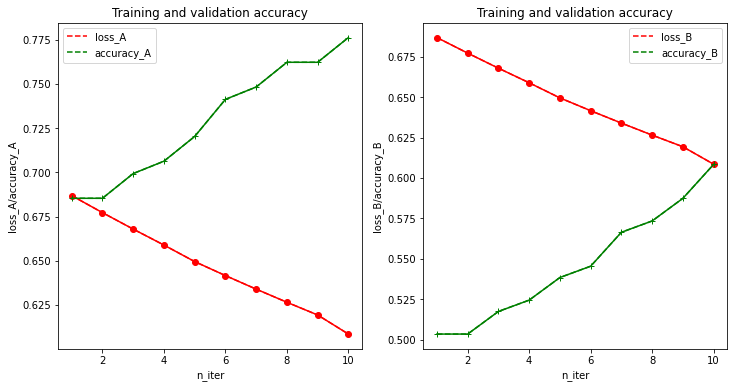

True

In [14]:
X, y, X_test, y_test = load_data()
config = {
    "n_iter": 10,
    "lambda": 2,
    "lr": 0.005,
    "A_idx": [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    "B_idx": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "epsilon": 8.0
    }
vertical_logistic_regression(X, y, X_test, y_test, config)